Training set: (17000, 28, 28, 1), Labels: (17000, 10)
Testing set: (3000, 28, 28, 1), Labels: (3000, 10)


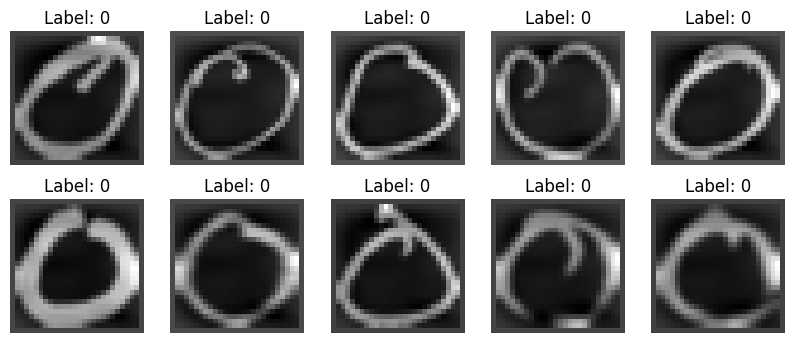

In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow
# Define dataset paths
train_dir = "/kaggle/input/devnagiri-hand-written/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/kaggle/input/devnagiri-hand-written/DevanagariHandwrittenDigitDataset/Test"
# Define image size
img_height, img_width = 28, 28
# Function to load images and labels using PIL
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
    class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]
        for filename in os.listdir(class_path):
              img_path = os.path.join(class_path, filename)
              # Load image using PIL
              img = Image.open(img_path).convert("L") # Convert to grayscale
              img = img.resize((img_width, img_height)) # Resize to (28,28)
              img = np.array(img) / 255.0 # Normalize pixel values to [0,1]
              images.append(img)
              labels.append(label)
    return np.array(images), np.array(labels)
# Load training and testing datasets
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)
# Reshape images for Keras input
x_train = x_train.reshape(-1, img_height, img_width, 1) # Shape (num_samples, 28, 28, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)

mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
# Print dataset shape
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")
# Visualize some images
plt.figure(figsize=(10, 4))
for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {np.argmax(y_train[i])}")
        plt.axis("off")
plt.show()

In [36]:
# Model parameters
import tensorflow as tf
from tensorflow import keras
num_classes = 10
input_shape = (28, 28, 1)
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation="relu"),
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation="relu"),
   
    
    keras.layers.Dense(num_classes, activation="softmax")  # Output Layer
])

In [37]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
optimizer="sgd", # Stochastic Gradient Descent
loss="categorical_crossentropy", # Loss function for multi-class classification
metrics=["accuracy"] # Track accuracy during training
)
   

In [45]:
batch_size = 32
epochs = 500
# Callbacks
callbacks = [
keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
keras.callbacks.EarlyStopping(monitor="val_loss", patience=10 ),
]
# Train the model with callbacks and validation split
history = model.fit(
x_train,
y_train,
batch_size=batch_size,
epochs=epochs,
validation_split=0.2,
callbacks=callbacks,
)

Epoch 1/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.0000e+00 - val_loss: 18.2091
Epoch 2/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9995 - loss: 0.0052 - val_accuracy: 0.0000e+00 - val_loss: 18.7781
Epoch 3/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.0000e+00 - val_loss: 18.5874
Epoch 4/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9997 - loss: 0.0039 - val_accuracy: 0.0000e+00 - val_loss: 19.3773
Epoch 5/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 0.0000e+00 - val_loss: 19.5756
Epoch 6/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 0.0031 - val_accuracy: 0.0000e+00 - val_loss: 20.0136
Epoch 7/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.0000e+00 - val_loss: 20.1049
Epoch 8/500
425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accurac

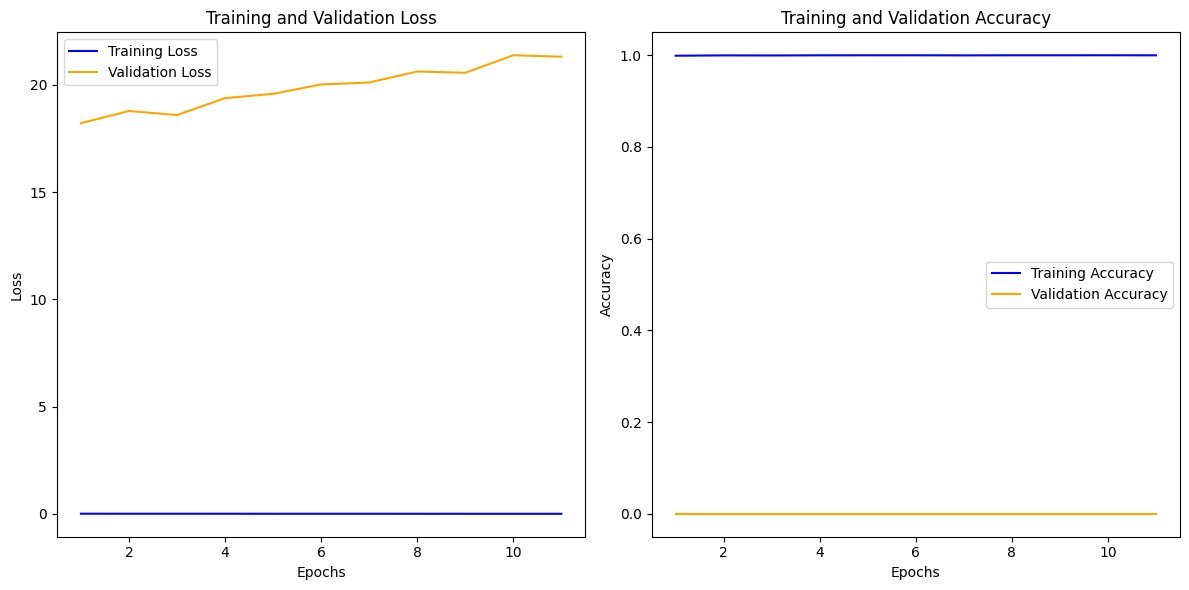

In [46]:
import matplotlib.pyplot as plt
# Assuming 'history' is the object returned by model.fit()
# Extracting training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Extracting training and validation accuracy (if metrics were specified)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

94/94 - 0s - 1ms/step - accuracy: 0.7937 - loss: 4.2624
Test accuracy: 0.7937


In [48]:
# Predict on test data
predictions = model.predict(x_test)
# Convert predictions from probabilities to digit labels
predicted_labels = np.argmax(predictions, axis=1)
# Check the first prediction
print(f"Predicted label for first image: {predicted_labels[0]}")
print(f"True label for first image: {np.argmax(y_test[0])}")
     

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predicted label for first image: 0
True label for first image: 0


In [9]:
model.save("mnist_fully_connected_model.h5")